# Example Usage


In [25]:
import numpy as np
import Py6S
from matplotlib import pyplot as plt

import splib07
from rtm_wrapper import Py6SDenseOutput, make_sixs_wrapper

# Setup

In [26]:
wl_spacing = 0.0025
wl = np.arange(0.4, 2.5 + wl_spacing, wl_spacing)

usgs_lib = splib07.Splib07("usgs_splib07.zip")
target_spec = usgs_lib.load("Cotton_Fabric_GDS437_White", resample=wl)
ground_spec = usgs_lib.load("Oak_Oak-Leaf-1_fresh", resample=wl)

s = make_sixs_wrapper()
s.aero_profile = Py6S.AeroProfile.PredefinedType(Py6S.AeroProfile.Maritime)
s.altitudes.set_target_sea_level()
s.altitudes.set_sensor_satellite_level()
# s.ground_reflectance = Py6S.GroundReflectance().HomogeneousLambertian(0.7)
# s.ground_reflectance = Py6S.GroundReflectance().HomogeneousLambertian(
#     np.stack((wl, ground_spec.spectrum), axis=-1)
# )
s.ground_reflectance = Py6S.GroundReflectance().HeterogeneousLambertian(
    radius=0.5,
    ro_target=np.stack((wl, target_spec.spectrum), axis=-1),
    ro_env=np.stack((wl, ground_spec.spectrum), axis=-1),
)

# Run experiment

In [27]:
_, raw_output_list = Py6S.SixSHelpers.Wavelengths.run_wavelengths(s, wl)

# Extract output arrays.
outputs = Py6SDenseOutput.from_py6s(raw_output_list)

Running for many wavelengths - this may take a long time


# Plot output radiance components

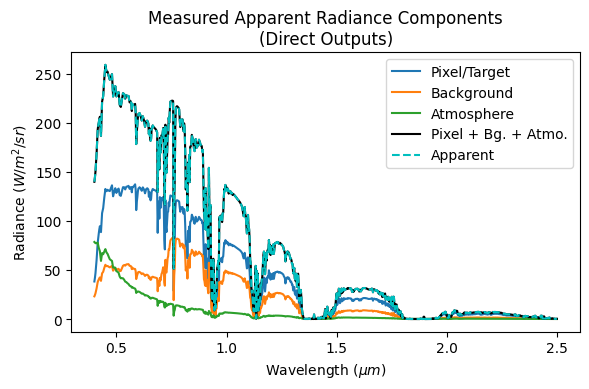

In [28]:
fig, ax = plt.subplots(figsize=(6, 4), layout="tight")

ax.plot(wl, outputs.pixel_radiance, label="Pixel/Target")
ax.plot(wl, outputs.background_radiance, label="Background")
ax.plot(wl, outputs.atmospheric_intrinsic_radiance, label="Atmosphere")
ax.plot(
    wl,
    outputs.pixel_radiance
    + outputs.background_radiance
    + outputs.atmospheric_intrinsic_radiance,
    label="Pixel + Bg. + Atmo.",
    color="k",
)
ax.plot(wl, outputs.apparent_radiance, label="Apparent", linestyle="--", color="c")

ax.legend()
ax.set_xlabel(r"Wavelength ($\mu m$)")
ax.set_ylabel(r"Radiance ($W/m^2/sr$)")
ax.set_title("Measured Apparent Radiance Components\n(Direct Outputs)");

# Plot derived radiance components

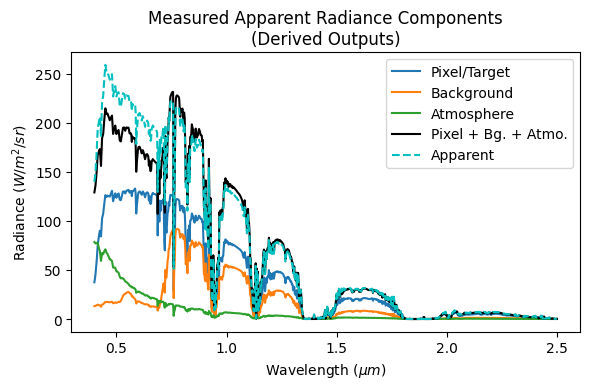

In [29]:
rho_t = s.ground_reflectance[-2][:, 1]
rho_b = s.ground_reflectance[-1][:, 1]
s_star = 1 / (1 - rho_b * outputs.spherical_albedo["total"])
l_target = (
    outputs.cos_zenith_solar
    * outputs.solar_spectrum
    * outputs.transmittance_global_gas["total"]
    * (outputs.transmittance_direct_down + outputs.transmittance_diffuse_down)
    * outputs.transmittance_direct_up
    * rho_t
    * s_star
) / np.pi
l_background = (
    outputs.cos_zenith_solar
    * outputs.solar_spectrum
    * outputs.transmittance_global_gas["total"]
    * (outputs.transmittance_direct_down + outputs.transmittance_diffuse_down)
    * outputs.transmittance_diffuse_up
    * rho_b
    * s_star
) / np.pi
l_diff_amto = (
    outputs.cos_zenith_solar
    * outputs.solar_spectrum
    * outputs.atmospheric_intrinsic_reflectance
) / np.pi
l_model = l_target + l_background + l_diff_amto

fig, ax = plt.subplots(figsize=(6, 4), layout="tight")
ax.plot(wl, l_target, label="Pixel/Target")
ax.plot(wl, l_background, label="Background")
ax.plot(wl, l_diff_amto, label="Atmosphere")
ax.plot(
    wl,
    l_model,
    label="Pixel + Bg. + Atmo.",
    color="k",
)
ax.plot(wl, outputs.apparent_radiance, label="Apparent", linestyle="--", color="c")
ax.legend()
ax.set_xlabel(r"Wavelength ($\mu m$)")
ax.set_ylabel(r"Radiance ($W/m^2/sr$)")
ax.set_title("Measured Apparent Radiance Components\n(Derived Outputs)");